### Problem description

Here we seek to solve

\begin{align*}
\min_{\rho\in H^{1}(\Omega)}f(\rho)&:=\frac{1}{2}\int_{\Omega}\nabla\rho\cdot\nabla\rho\,\mathrm{d}V\\
\Omega&=\left(0,1\right)\subset\mathbb{R}
\end{align*}

such that

\begin{align*}
\int_{\Omega}\rho\,\mathrm{d}V&\leq \Omega_{f} \\
\rho(x=0)&=\rho_{0} \\
\rho(x=1)&=\rho_{1} \\
\rho(x)&\geq \rho_{\ell}(x)\quad x\in\overline{\Omega}
\end{align*}

We introduce a slack variable $y\in\mathbb{R}$, so that the equivalent reformulation is compatible with the structure of the developed filter line search software, that is we seek to solve

\begin{align*}
\min_{(\rho,y)\in H^{1}(\Omega)\times\mathbb{R}}f(\rho,y)&:=\frac{1}{2}\int_{\Omega}\nabla\rho\cdot\nabla\rho\,\mathrm{d}V\\
\Omega&=\left(0,1\right)\subset\mathbb{R}
\end{align*}

such that

\begin{align*}
\int_{\Omega}\rho\,\mathrm{d}V+y-\Omega_{f}&=0 \\
\rho(x=0)&=\rho_{0} \\
\rho(x=1)&=\rho_{1} \\
\rho(x)&\geq \rho_{\ell}(x)\quad x\in\overline{\Omega} \\
y &\geq 0
\end{align*}




In [1]:
import dolfin as dl
import numpy as np
import matplotlib.pyplot as plt
from filterLineSearch import interior_pt

In [2]:
nx = 20
mesh = dl.UnitIntervalMesh(nx)
Vh1 = dl.FunctionSpace(mesh, 'CG', 1)
test = dl.TestFunction(Vh1)
trial = dl.TrialFunction(Vh1)

Kform = dl.inner(dl.grad(test), dl.grad(trial))*dl.dx(mesh)
K     = dl.assemble(Kform).array()
Mform = test * trial * dl.dx(mesh)
M     = dl.assemble(Mform).array()

In [3]:
class example3:
    def __init__(self, nx, K, M, rhol, Omegaf, rho0, rho1):
        self.K    = K
        self.M    = M
        self.nx   = nx
        self.Omegaf = Omegaf
        self.rho0   = rho0
        self.rho1   = rho1
        self.n1   = 0
        self.n2   = self.nx + 1
        self.n    = self.n1 + self.n2
        self.m    = 3
        self.rhol = np.append(rhol, 0.) # add extra constraint for slack variable
    def f(self, x):
        return 0.5 * np.inner(x[:self.nx], np.dot(self.K, x[:self.nx]))
    def Dxf(self, x):
        y = np.zeros(self.n)
        y[:self.nx] = np.dot(self.K, x[:self.nx])
        return y
    def Dxxf(self, x):
        y = np.zeros((self.n, self.n))
        y[:self.nx, :self.nx] = K[:, :]
        return y
    def c(self, x):
        y = np.zeros(self.m)
        y[0] = sum(self.M.dot(x[:self.nx])) + x[-1] - self.Omegaf
        y[1] = x[0] - self.rho0
        y[2] = x[self.nx-1] - self.rho1
        return y
    def theta(self, x):
        return np.linalg.norm(self.c(x), 2)
    def Dxc(self, x):
        J = np.zeros((self.m, self.n))
        one = np.ones(self.nx)
        J[0, :self.nx]    = self.M.dot(one)
        J[0, self.nx]     = 1.
        J[1, 0]           = 1.
        J[2, self.nx - 1] = 1.
        return J
    def Dxxc(self, x):
        y = np.zeros((self.m, self.n, self.n))
        return y
    def phi(self, x, mu):
        return self.f(x) - mu * sum(np.log(x[self.n1:] - self.rhol))
    def Dxphi(self, x, mu):
        rho = x[self.n1:]
        return self.Dxf(x) - mu / (rho - self.rhol)
    def L(self, X):
        x, lam, z = X[:]
        rho = x[self.n1:]
        return (self.f(x) + np.inner(lam, self.c(x)) - np.inner(z, rho - self.rhol))
    def DxL(self, X):
        x, lam, z = X[:]
        y = np.zeros(self.n)
        y = self.Dxf(x) + np.dot(lam.T, self.Dxc(x))
        y[self.n1:] -= z[:]
        return y
    def DxxL(self, X):
        x, lam, z = X[:]
        y = np.zeros((self.n, self.n))
        y[:, :] += self.Dxxf(x)
        y[:, :] += np.tensordot(self.Dxxc(x), lam, axes=([0,0]))
        return y
    def E(self, X, mu, smax):
        x, lam, z = X[:]
        rho = x[self.n1:]
        E1 = np.linalg.norm(self.DxL(X), np.inf)
        E3 = np.linalg.norm((rho - self.rhol)*z-mu, np.inf)
        laml1 = np.linalg.norm(lam, 1)
        zl1   = np.linalg.norm(z,   1)
        sd    = max(smax, (laml1 + zl1) / (self.m + self.n2)) / smax
        sd    = 1.
        sc    = max(smax, zl1 / self.n2) / smax
        if self.m > 0:
            E2 = np.linalg.norm(self.c(x), np.inf)
            return max(E1 / sd, E2, E3 / sc), E1, E2, E3
        else:
            return max(E1 / sd, E3 / sc)

        
        

In [4]:
Omegaf = 0.1
rhol   = 0.0*np.ones(Vh1.dim())
rho0   = 0.05
rho1   = 0.05   

problem = example3(Vh1.dim(), K, M, rhol, Omegaf, rho0, rho1)

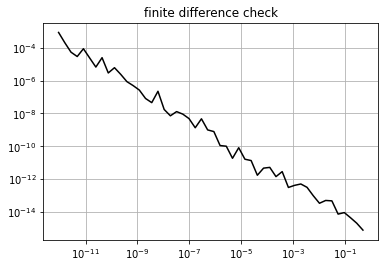

In [5]:
#---- gradient checks

epss  = np.logspace(1, 40, base=0.5)
x0    = 2. + np.abs(np.random.randn(problem.n))
F     = lambda x : problem.c(x)
gradF = lambda x : problem.Dxc(x)
F0   = F(x0)
gradF0   = gradF(x0)
xhat = np.random.randn(problem.n)
grad_err = np.zeros(len(epss))
for j, eps in enumerate(epss):
    Fplus = F(x0 + eps*xhat)
    if len(gradF0.shape) > 1:
        grad_err[j] = np.linalg.norm((Fplus - F0)/ eps - np.dot(gradF0, xhat), 2)
    else:
        grad_err[j] = np.abs((Fplus - F0) / eps - np.inner(gradF0, xhat))
plt.plot(epss, grad_err, 'k')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title('finite difference check')
plt.show()


In [6]:
solver  = interior_pt(problem)

x0      = 1. * np.ones(problem.n)
X0      = [x0, np.ones(problem.m), np.ones(problem.n2)]
solver.initialize(X0)
complementarity0 = np.linalg.norm(X0[2][:]*(x0[problem.n1:] - problem.rhol[:]), np.inf)
feasibility0     = problem.theta(x0)
optimality0      = np.linalg.norm(problem.DxL(X0), 2)

mu0 = 1.e0
tol = 1.e-8
max_it = 30
Xf, mu, E, Mus = solver.solve(tol, max_it, mu0)



-------------------------------------------------- it = 0
solved barrier problem (mu = 1.000e+00)
solved barrier problem (mu = 5.000e-01)
solved barrier problem (mu = 2.500e-01)
-------------------------------------------------- determining search direction 
KKT sys error = 2.821e-15
inertia of IP-Newton system matrix = (22, 3, 0)
inertia (to guarantee descent near feasible points) = (22, 3, 0)
smallest eigenvalue by magnitude = 1.80e-01
cond(Wk(delta=0)) = 8.06e+01
NO INERTIA CORRECTION WAS REQUIRED
alpha = 5.808e-01, alphaz = 1.000e+00
in filter region?  False
A.5.4
theta(x) = 2.33e+00
angle between xhat and Dxphi = 35.4 (degrees)
descent direction?  False
theta(x) < theta_min?  False
step accepted A-5.4 CASE II
linesearch success?  True
accepted trial point for the subproblem
-------------------------------------------------- it = 1
solved barrier problem (mu = 1.250e-01)
-------------------------------------------------- determining search direction 
KKT sys error = 5.733e-15
inert

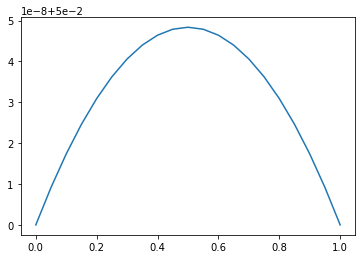

[0.05       0.05000001 0.05000002 0.05000002 0.05000003 0.05000004
 0.05000004 0.05000004 0.05000005 0.05000005 0.05000005 0.05000005
 0.05000005 0.05000004 0.05000004 0.05000004 0.05000003 0.05000002
 0.05000002 0.05000001 0.05       0.04999997]


In [7]:
rhosolution = dl.Function(Vh1)
rhosolution.vector().set_local(Xf[0][:-1])
dl.plot(rhosolution)
plt.show()
print(Xf[0])

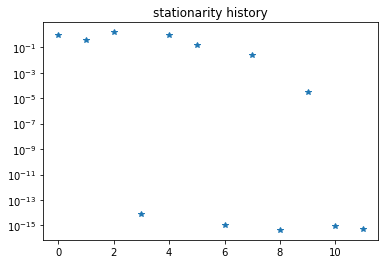

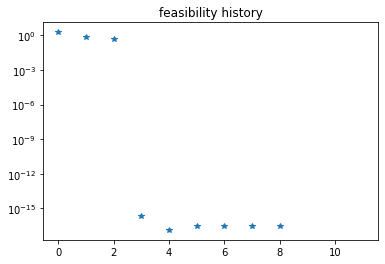

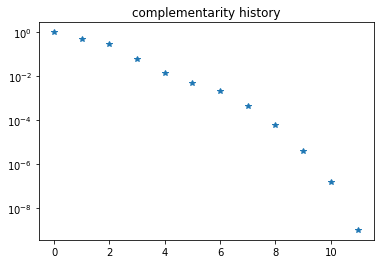

In [8]:
Es = [np.array([E[i][j] for i in range(len(E))]) for j in range(len(E[0]))]

titles = ["stationarity", "feasibility", "complementarity"]
for j in range(1,4):
    plt.plot(Es[j], "*")
    plt.title(titles[j-1] + " history")
    plt.yscale('log')
    plt.show()